In [1]:
from alpha_vantage.foreignexchange import ForeignExchange
import matplotlib.pyplot as plt
cc = ForeignExchange(key='OGRPFV5D58LC77OL',output_format='pandas')
import pandas as pd
from datetime import datetime
import numpy as np
from numpy.polynomial.polynomial import polyfit
import statistics

dfm = pd.DataFrame()
dfw = pd.DataFrame()
dfd = pd.DataFrame()

if dfm.empty:
    dfm, meta_data = cc.get_currency_exchange_monthly(from_symbol='EUR',to_symbol='USD', outputsize='full')

if dfw.empty:
    dfw, meta_data = cc.get_currency_exchange_weekly(from_symbol='EUR',to_symbol='USD', outputsize='full')  
    
if dfd.empty:
   dfd, meta_data = cc.get_currency_exchange_daily(from_symbol='EUR',to_symbol='USD', outputsize='full')


df60, meta_data = cc.get_currency_exchange_intraday(from_symbol='EUR',to_symbol='USD',interval='60min', outputsize='full')

## Data cleaning and shaping

In [2]:
def clean_Columns(df):
    if 'errorslope' not in df.columns:
        df.reset_index(inplace=True) #reset index to get timestamp out
        df.columns = ['date','open','high','low','close'] #Make sure column names are legit  
        df['index'] = np.arange(len(df)) #create an index 
        df['hilow_median'] = df[['high', 'low']].median(axis=1)
    return df

#Cleanup columns
clean_Columns(dfm)
clean_Columns(dfw)
clean_Columns(dfd)
#clean_Columns(df60)

#For some fuckin reason this has to be done in this order to filter out the weekends...
df60.reset_index(inplace=True) #reset index to get timestamp out
df60.columns = ['date','open','high','low','close'] #Make sure column names are legit 
df60 = df60[df60['date'].dt.weekday < 5] #Filter out all weekend data
df60['index'] = np.arange(len(df60)) #create an index 
df60['errorslope']=np.nan
df60['hilow_median'] = df60[['high', 'low']].median(axis=1)
df60['high_diff']=np.nan
df60['low_diff']=np.nan

## Make copies and Reshape the data

In [26]:
#Make copies
dfm_copy = dfm.copy()
dfw_copy = dfw.copy()
dfd_copy = dfd.copy()

#Filter the dates
dfm_copy = dfm_copy[dfm_copy['index'] < 18]
dfw_copy = dfw_copy[dfw_copy['index'] < 10]
dfd_copy = dfd_copy[dfd_copy['index'] < 30]

#determine ADR

## PLot the results

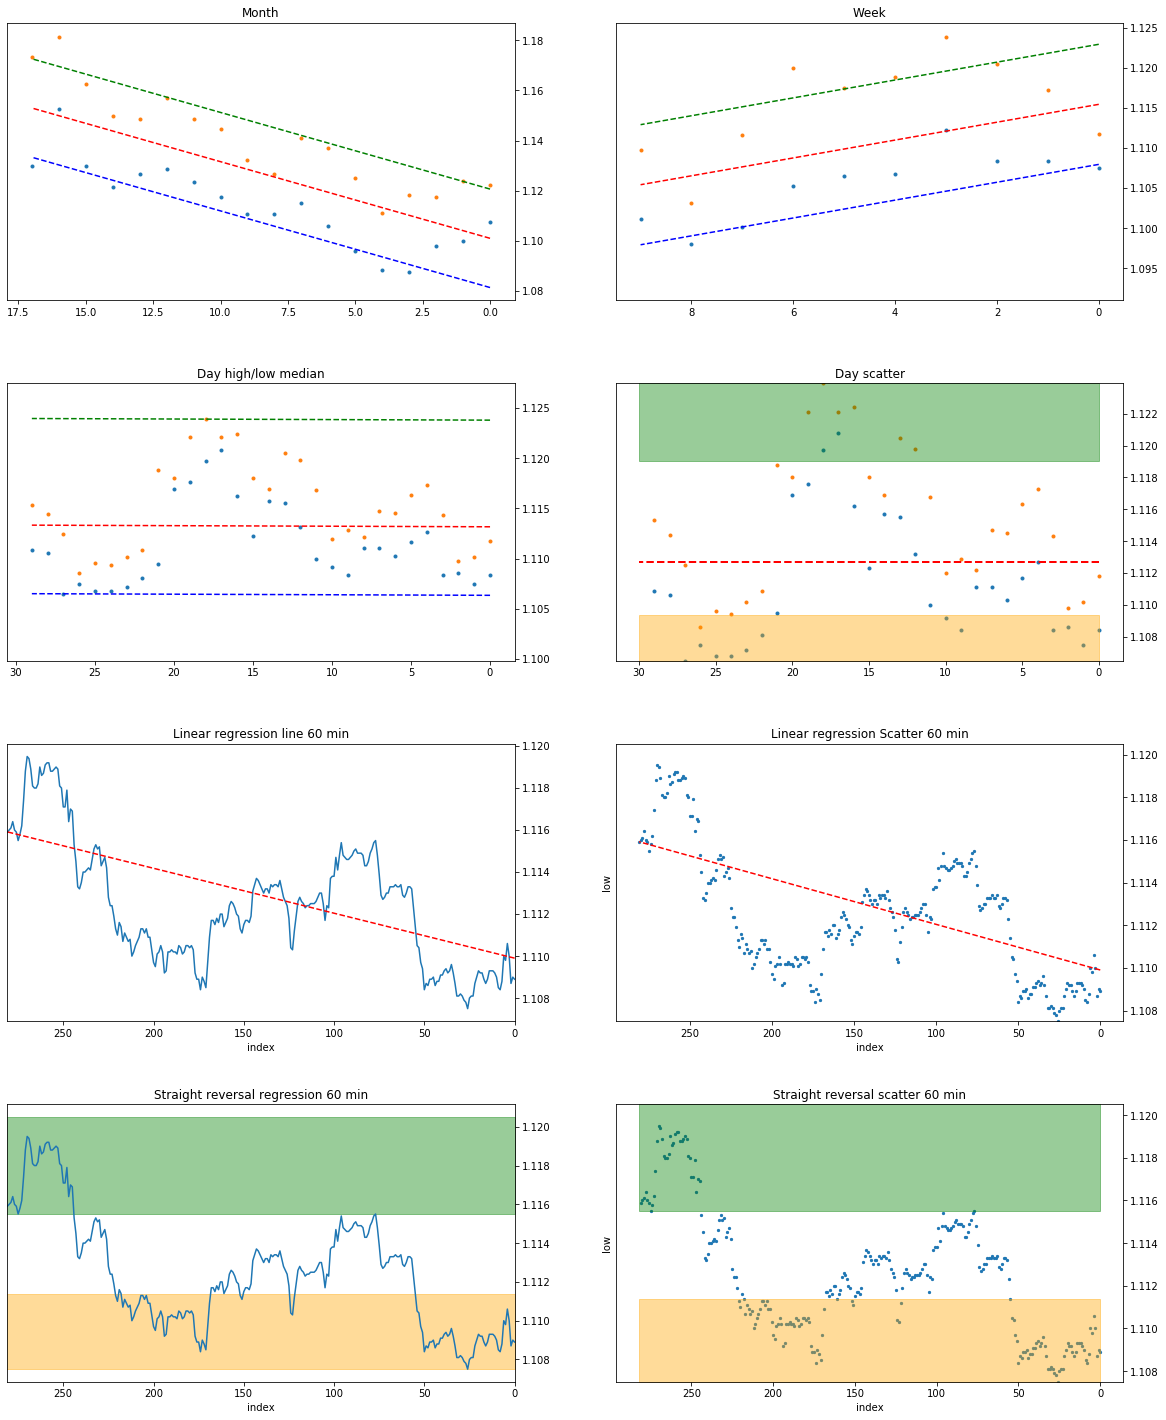

In [27]:
_val = 'low'
_low = 'low'
hilow_median = 'hilow_median'

#_monthsback = 

def Shade_Reversal_Zones(df,ax):
    ax.fill_between([0,df['index'].count()],df['high'].max(), df['high'].quantile(0.8), alpha=0.4,color='green')
    ax.fill_between([0,df['index'].count()],df['low'].min(),df['low'].quantile(0.8),alpha=0.4,color='orange')

def getregresion_line(df):
    if 'regress' not in df.columns:
        b, m = polyfit(df['index'], df[hilow_median], 1)
        a = (df['index'], b + m * df['index'])
        dft = a[1]
        obj = pd.DataFrame(dft) 
        obj.reset_index(inplace=True)
        obj.rename(columns={'level_0': 'index', 'index': 'regress'}, inplace=True)
        df = df.merge(obj,on='index',how='left')
        return df

def Set_Ylim(df,ax):
    ax.set_ylim([df['low'].min(),df['high'].max()])

def Plot_HiLowBars(df,ax):
    ax.fill_between([0,df['index'].count()],df['high'].max(), df['high'].quantile(0.8), alpha=0.4,color='green')
    ax.fill_between([0,df['index'].count()],df['low'].min(),df['low'].quantile(0.4),alpha=0.4,color='orange')
    ax.yaxis.tick_right()
    #ax.invert_xaxis()

def Plot_errorLine(df,ax):
    b, m = polyfit(df['index'], df[hilow_median], 1)
    ax.plot(df['index'], b + m * df['index'], 'r--')
    ax.yaxis.tick_right()
    
def plot_Reversal_Extremes_HTF(df,ax):
    b, m = polyfit(df['index'], df[hilow_median], 1)
    ax.plot(df['index'], b + m * df['index'], 'r--')
    ax.yaxis.tick_right()
    a = df['high']-df['low']
    a = (a.mean())*0.75
    ax.plot(df['index'], a + (b + m * df['index']), 'g--')
    ax.plot(df['index'], (b + m * df['index']) - a, 'b--')
    
def plot_Reversal_Extremes_LTF(df,ax):
    #df['regress'] = np.nan
    b, m = polyfit(df['index'], df[hilow_median], 1)
    ax.plot(df['index'], b + m * df['index'], 'r--')
    ax.yaxis.tick_right()
    diffhigh = (df.loc[df.high.idxmax(), 'regress'])
    diffhigh = df['high'].max() - diffhigh
    diffLow = (df.loc[df.low.idxmin(), 'regress'])
    diffLow = df['low'].min() - diffLow    
    ax.plot(df['index'], diffhigh + (b + m * df['index']), 'g--')
    ax.plot(df['index'], (b + m * df['index']) + diffLow, 'b--')
    
    
def Plot_Medians(df,ax):
     median = (df['high'].max() - df['low'].min())/2
     #mean= np.mean(df.loc[:,'hilow_median'])
     ax.hlines(df.loc[:,'hilow_median'].median(), 0,len(df['index']),color='r', linestyles='--', lw=2)
     #ax.hlines(median, 0,len(df['index']),color='r', linestyles='--', lw=2)
     #trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
     #ax.text(0,mean, "{:.0f}".format(mean), color="red", transform=trans,ha="right", va="center")
         
       
#Set the main figure proportions
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.3)

# Divide the figure into a 2x2 grid, and set sections to ax1 and ax2
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)


#Monthly
ax1.scatter(dfm_copy['index'], dfm_copy['low'], marker='.')
ax1.scatter(dfm_copy['index'], dfm_copy['high'], marker='.')

#Weekly
ax2.scatter(dfw_copy['index'], dfw_copy['low'], marker='.')
ax2.scatter(dfw_copy['index'], dfw_copy['high'], marker='.')

#Daily 
ax3.scatter(dfd_copy['index'], dfd_copy['low'], marker='.')
ax3.scatter(dfd_copy['index'], dfd_copy['high'], marker='.')

#Daily scatter plot
ax4.scatter(dfd_copy['index'], dfd_copy['low'], marker='.')
ax4.scatter(dfd_copy['index'], dfd_copy['high'], marker='.')

#60 minute
df60.plot(x='index', y=_val, ax=ax5, legend=False)
df60.plot(x='index', y=_val, ax=ax6, kind = 'scatter', marker='.')
df60.plot(x='index', y=_val, ax=ax7, legend=False)
df60.plot(x='index', y=_val, ax=ax8, kind = 'scatter',marker='.')

#for some reason I have to invert these axis
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
ax7.invert_xaxis()
ax8.invert_xaxis()

#ax1.yaxis.set_label_text("Month")
ax1.set_title("Month")
ax2.set_title("Week")
ax3.set_title("Day high/low median")
ax4.set_title("Day scatter")
ax5.set_title('Linear regression line 60 min')
ax6.set_title('Linear regression Scatter 60 min')
ax7.set_title('Straight reversal regression 60 min')
ax8.set_title('Straight reversal scatter 60 min')

#Set the chart y limits
Set_Ylim(dfd_copy,ax4)
Set_Ylim(df60,ax6)
Set_Ylim(df60,ax8)

#populate the regression line
dfm_copy = getregresion_line(dfm_copy)
dfw_copy = getregresion_line(dfw_copy)
dfd_copy = getregresion_line(dfd_copy)
#df60 = getregresion_line(df60)

#Plot the sloping line
Plot_errorLine(df60,ax5)
Plot_errorLine(df60,ax6)

#Plot the sideways median line
plot_Reversal_Extremes_HTF(dfm_copy,ax1)
plot_Reversal_Extremes_HTF(dfw_copy,ax2)
plot_Reversal_Extremes_LTF(dfd_copy,ax3)
Plot_Medians(dfd_copy,ax4)

#Plot the 20% ranges fior high and low bars
Plot_HiLowBars(dfd_copy,ax4)
Plot_HiLowBars(df60,ax7)
Plot_HiLowBars(df60,ax8)


In [5]:
#df = df60.copy()
#df60[df60.timestamp > '2020-01-12 18:00:00']
#df[df['timestamp'].isin(['2020-01-13','2020-01-07'])]
#df.mean()
#pieces = [df[:1], df[:3], df[4:]] # Chop a datraframe into pieces
#df['day'] = df['timestamp'].dt.day_name() #Create a column of day names
#df.groupby('day')
#df.set_index('day', inplace=True)
#pd.set_option('display.max_rows', 500)
#gf.set_index(['day','Date','time'], inplace=True)
#gf.to_csv('filtered.csv')
#gf.dtypes
#stacked = gf.stack()
#pd.set_option('display.max_rows', 500)

In [6]:
df = dfd_copy.copy()
b, m = polyfit(df['index'], df[hilow_median], 1)
a = (df['index'], b + m * df['index'])
dft = a[1]
obj = pd.DataFrame(dft) 
obj.reset_index(inplace=True)
obj.rename(columns={'level_0': 'index', 'index': 'regress'}, inplace=True)
df = df.merge(obj,on='index',how='left')
df

,date,open,high,low,close,index,hilow_median,regress_x,regress_y
0,2020-01-21,1.1096,1.1118,1.1084,1.1091,0,1.11010,1.113175,1.113175
1,2020-01-20,1.1091,1.1102,1.1075,1.1096,1,1.10885,1.113181,1.113181
2,2020-01-19,1.1094,1.1098,1.1086,1.1090,2,1.10920,1.113187,1.113187
3,2020-01-17,1.1137,1.1143,1.1084,1.1088,3,1.11135,1.113192,1.113192
4,2020-01-16,1.1152,1.1173,1.1127,1.1137,4,1.11500,1.113198,1.113198
5,2020-01-15,1.1126,1.1163,1.1117,1.1152,5,1.11400,1.113203,1.113203
6,2020-01-14,1.1135,1.1145,1.1103,1.1126,6,1.11240,1.113209,1.113209
7,2020-01-13,1.1117,1.1147,1.1111,1.1135,7,1.11290,1.113215,1.113215
8,2020-01-12,1.1118,1.1122,1.1111,1.1117,8,1.11165,1.113220,1.113220
9,2020-01-10,1.1106,1.1129,1.1084,1.1120,9,1.11065,1.113226,1.113226


In [7]:
dfd_copy

,date,open,high,low,close,index,hilow_median,regress
0,2020-01-21,1.1096,1.1118,1.1084,1.1091,0,1.11010,1.113175
1,2020-01-20,1.1091,1.1102,1.1075,1.1096,1,1.10885,1.113181
2,2020-01-19,1.1094,1.1098,1.1086,1.1090,2,1.10920,1.113187
3,2020-01-17,1.1137,1.1143,1.1084,1.1088,3,1.11135,1.113192
4,2020-01-16,1.1152,1.1173,1.1127,1.1137,4,1.11500,1.113198
5,2020-01-15,1.1126,1.1163,1.1117,1.1152,5,1.11400,1.113203
6,2020-01-14,1.1135,1.1145,1.1103,1.1126,6,1.11240,1.113209
7,2020-01-13,1.1117,1.1147,1.1111,1.1135,7,1.11290,1.113215
8,2020-01-12,1.1118,1.1122,1.1111,1.1117,8,1.11165,1.113220
9,2020-01-10,1.1106,1.1129,1.1084,1.1120,9,1.11065,1.113226


In [8]:
#dfd_copy
diff2 = (dfd_copy.loc[dfd_copy.high.idxmin(), 'regress'])
diff2 = dfd_copy['low'].min() - diff2
diff2


-0.006821138301817298

In [9]:
dfd_copy

,date,open,high,low,close,index,hilow_median,regress
0,2020-01-21,1.1096,1.1118,1.1084,1.1091,0,1.11010,1.113175
1,2020-01-20,1.1091,1.1102,1.1075,1.1096,1,1.10885,1.113181
2,2020-01-19,1.1094,1.1098,1.1086,1.1090,2,1.10920,1.113187
3,2020-01-17,1.1137,1.1143,1.1084,1.1088,3,1.11135,1.113192
4,2020-01-16,1.1152,1.1173,1.1127,1.1137,4,1.11500,1.113198
5,2020-01-15,1.1126,1.1163,1.1117,1.1152,5,1.11400,1.113203
6,2020-01-14,1.1135,1.1145,1.1103,1.1126,6,1.11240,1.113209
7,2020-01-13,1.1117,1.1147,1.1111,1.1135,7,1.11290,1.113215
8,2020-01-12,1.1118,1.1122,1.1111,1.1117,8,1.11165,1.113220
9,2020-01-10,1.1106,1.1129,1.1084,1.1120,9,1.11065,1.113226
